In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model

In [20]:
# === Configuration ===
IMG_SIZE = 300
SAMPLES_PER_CLASS = 450
USE_GRIDSEARCH = False
DATA_DIR = r"E://Projects//paddy//paddydisease"   # change if needed
METADATA_PATH = os.path.join(DATA_DIR, "metadata.csv")
VALID_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

In [21]:
# === Helper: check if folder has at least one image ===
def folder_has_images(folder_path):
    if not os.path.isdir(folder_path):
        return False
    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith(VALID_EXTS):
                return True
    return False

In [22]:
# === Determine valid image class folders under DATA_DIR ===
all_entries = os.listdir(DATA_DIR)
valid_label_folders = []
for entry in all_entries:
    full_path = os.path.join(DATA_DIR, entry)
    if os.path.isdir(full_path) and folder_has_images(full_path):
        valid_label_folders.append(entry)

valid_label_set = set(valid_label_folders)
print("Valid image label folders found:", valid_label_folders)

Valid image label folders found: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'black_stem_borer', 'blast', 'brown_spot', 'downy_mildew', 'hispa', 'leaf_roller', 'normal', 'tungro', 'white_stem_borer', 'yellow_stem_borer']


In [23]:
# === Load Metadata ===
metadata = pd.read_csv(METADATA_PATH)

label_col = "label" if "label" in metadata.columns else "disease_name"
filename_col = "filename" if "filename" in metadata.columns else "image_id"

metadata = metadata.dropna(subset=[label_col, filename_col])
metadata[label_col] = metadata[label_col].astype(str)
metadata = metadata.rename(columns={label_col: "label", filename_col: "filename"})

In [24]:
# Keep only rows whose label corresponds to a real image folder
before_rows = len(metadata)
metadata = metadata[metadata["label"].isin(valid_label_set)]
after_rows = len(metadata)
print(f"Metadata rows before filtering: {before_rows}, after filtering: {after_rows}")

Metadata rows before filtering: 16225, after filtering: 16225


In [25]:
# === Balance Dataset ===
balanced_df = (
    metadata.groupby("label")
    .apply(
        lambda x: x.sample(SAMPLES_PER_CLASS, random_state=42)
        if len(x) >= SAMPLES_PER_CLASS
        else x
    )
    .reset_index(drop=True)
)
print(f"Balanced samples: {len(balanced_df)}")

Balanced samples: 5850


C:\Users\Eshwar\AppData\Local\Temp\ipykernel_15872\4089333044.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [26]:
# === Load EfficientNetB3 ===
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

In [27]:
# === Feature Extraction ===
def extract_feature(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        features = feature_extractor.predict(
            np.expand_dims(img, axis=0), verbose=0
        )
        return features.squeeze()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return None

X, y = [], []
for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    label = row["label"]
    filename = row["filename"]
    img_path = os.path.join(DATA_DIR, label, filename)

    # extra safety: skip if file does not exist or is not an image
    if not os.path.isfile(img_path):
        # print(f"[WARN] Missing file: {img_path}")
        continue
    if not img_path.lower().endswith(VALID_EXTS):
        continue

    features = extract_feature(img_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

print(f"\nFeature shape: {X.shape}, Labels shape: {y.shape}")

100%|██████████| 5850/5850 [18:47<00:00,  5.19it/s]


Feature shape: (5850, 1536), Labels shape: (5850,)


In [28]:
# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [29]:
# === Random Forest Classifier (with Optional GridSearch) ===
if USE_GRIDSEARCH:
    param_grid = {
        "n_estimators": [300, 400],
        "max_depth": [30, 40, 50],
        "max_features": ["sqrt"],
        "class_weight": ["balanced", "balanced_subsample"],
    }

    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        n_jobs=-1,
        verbose=1,
    )
    rf_grid.fit(X_train, y_train)
    clf = rf_grid.best_estimator_
    print(f"Best Params: {rf_grid.best_params_}")
else:
    clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=40,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1,
    )
    clf.fit(X_train, y_train)

In [30]:
# === Evaluation ===
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 82.74%

Classification Report:
                           precision    recall  f1-score   support

   bacterial_leaf_blight       0.84      0.87      0.85        90
   bacterial_leaf_streak       0.98      0.99      0.98        90
bacterial_panicle_blight       0.88      0.90      0.89        90
        black_stem_borer       0.92      0.93      0.93        90
                   blast       0.71      0.71      0.71        90
              brown_spot       0.78      0.76      0.77        90
            downy_mildew       0.88      0.80      0.84        90
                   hispa       0.78      0.79      0.78        90
             leaf_roller       0.92      0.77      0.84        90
                  normal       0.76      0.82      0.79        90
                  tungro       0.63      0.74      0.68        90
        white_stem_borer       0.83      0.79      0.81        90
       yellow_stem_borer       0.90      0.89      0.89        90

                accuracy       

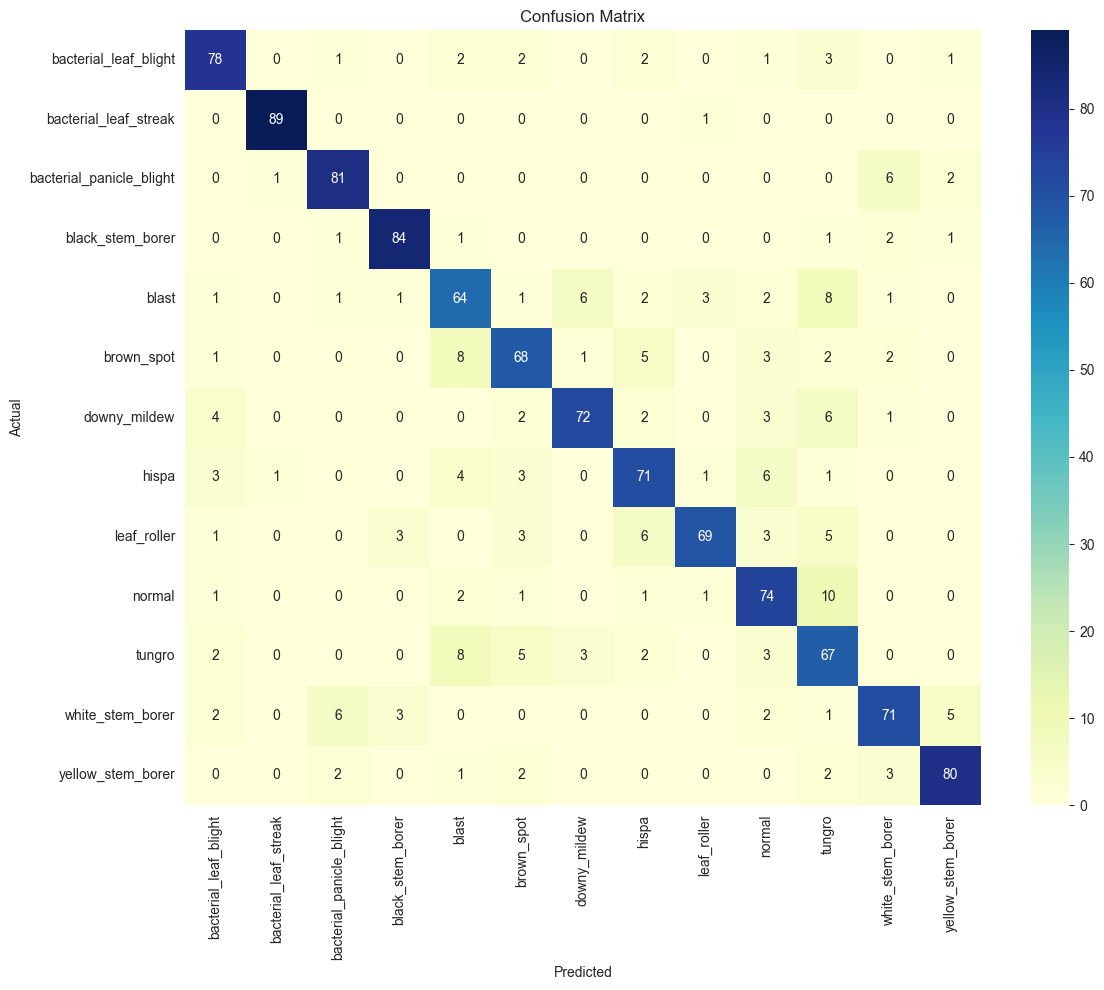

In [31]:
# === Confusion Matrix ===
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
plot_confusion_matrix(cm, sorted(np.unique(y)))

In [32]:
# === Feature Importance (Top 10) ===
importances = clf.feature_importances_
top_idx = np.argsort(importances)[-10:]
print("\nTop 10 feature indices used by RF:")
print(top_idx[::-1])

# === Optional: Export Misclassified Predictions ===
save_misclassified = False
if save_misclassified:
    misclassified = []
    for true, pred in zip(y_test, y_pred):
        if true != pred:
            misclassified.append((true, pred))
    pd.DataFrame(
        misclassified,
        columns=["True_Label", "Predicted_Label"]
    ).to_csv("misclassified.csv", index=False)
    print("Saved misclassified predictions.")


Top 10 feature indices used by RF:
[ 321 1431 1235   24  414   88  975  342  312  230]
